In [0]:
# download data (-q is the quiet mode)
! wget -q https://www.dropbox.com/s/lhb1awpi769bfdr/test.csv?dl=1 -O test.csv
! wget -q https://www.dropbox.com/s/gudb5eunj700s7j/train.csv?dl=1 -O train.csv



traning 7631
testing 7632


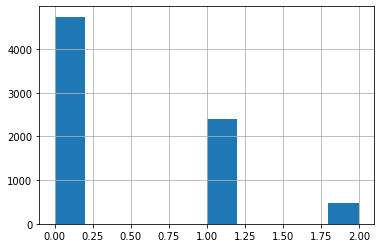

In [7]:
import pandas as pd

Xy_train = pd.read_csv('train.csv', engine='python')
X_train = Xy_train.drop(columns=['price_rating'])
y_train = Xy_train[['price_rating']]

print('traning', len(X_train))
Xy_train.price_rating.hist()

X_test = pd.read_csv('test.csv', engine='python')
testing_ids = X_test.Id
print('testing', len(X_test))


In [8]:
# model training and tuning
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0)

numeric_features = ['bedrooms', 'review_scores_location', 'accommodates', 'beds']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [
  'property_type', 'is_business_travel_ready', 'room_type', ]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', XGBClassifier(
                          objective='multi:softmax', seed=1))])


X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]

# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb)
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth':[10, 20]
}

grid_search = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='accuracy')
grid_search.fit(X_train, y_train)

print('best score {}'.format(grid_search.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   41.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best score 0.6945360101828082


In [0]:
# Prediction & generating the submission file
y_pred = grid_search.predict(X_test)
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred}).to_csv('sample_submission.csv', index=False)